# 強化学習を始める前に
## 強化学習ってなんだっけ

強化学習は行動をすると報酬を与える環境を与えて、学習、モデルを生成する機械学習の１つの形態です。

## 迷路を解いてみよう

ここでは、以下のような迷路を例にとって強化学習の「前に」必要な知識の習得を行います。

<img src="resources/maze.png" width="25%">


### ルール

この迷路は壁はなく、盤内ならどこへでも動けます。ただし、行動するだけで毎回スコアが0.04引かれます。
また、トラップがあり、そのマスに乗るとスコアが-1され、そこでゲームは終了となります。
ゴールすると１点獲得し、そこでゲームは終了します。

## 迷路の定義
迷路は以下の通り定義しています。

In [19]:
from enum import IntEnum
import numpy as np

class UserState:
    def __init__(self, y=-1, x=-1, score=0):
        self.y = y
        self.x = x
        self.score=score
    
    def __repr__(self):
        return "<State: [{},{}]>".format(self.x, self.y)
    
    def clone(self):
        return UserState(self.y, self.x)
    
    def __hash__(self):
        return hash((self.y, self.x))
    
    def __eq__(self, other):
        return self.y == other.y and self.x == other.x

class MazeAction(IntEnum):
    UP    =  0
    DOWN  =  1
    LEFT  =  2
    RIGHT =  3
    
    
    def get_move_dir(action):
        return [ ( 0,  1), ( 0, -1), (-1,  0), ( 1,  0)][action.value]

class MazeEnvironment:
    def __init__(self, map, move_prob=0.8, randomize=True):
        # map is maze map, 2d array
        #  0: road, continue game.
        #  1: goal, get 1 point
        # -1: damage, minus -1 point
        self.map        = map
        self.move_prob  = move_prob
        self.actions    = [ MazeAction.UP, MazeAction.DOWN, MazeAction.LEFT, MazeAction.RIGHT]
        self.user_state = UserState()
        
        self.y_length   = len(self.map)
        self.x_length = len(self.map[0])
        self.randomize = randomize
        
        self.penalty_by_turn = 0.004
        
    @property
    def states(self):
        states = []
        for y in range(self.y_length):
            for x in range(self.x_length):
                states.append(UserState(y, x))
        return states
        
    def reset(self):
        self.user_state = UserState(y=0, x=0, score=0)
        return self.user_state.clone()
        
    def is_game_end(self):
        x = self.user_state.x
        y = self.user_state.y
        if not self.map[y][x] == 0:
            return True
        return False
    
    def transition_probs(self, state, action):
        transition_probs = {}
        opposite = {
            MazeAction.UP.value: MazeAction.DOWN,
            MazeAction.DOWN.value: MazeAction.UP,
            MazeAction.LEFT.value: MazeAction.RIGHT,
            MazeAction.RIGHT.value: MazeAction.LEFT
        }
        if self.randomize:
            for a in self.actions:
                prob = 0
                if a == action:
                    prob = self.move_prob
                elif not a == opposite[action.value]:
                    prob = (1 - self.move_prob) / (len(self.actions)-2)

                next_state = self.get_next_state(state, a)

                if next_state not in transition_probs:
                    transition_probs[next_state]  = prob
                else:
                    transition_probs[next_state] += prob
        else:
            next_state = self.get_next_state(state, action)
            transition_probs[next_state] = 1
        return transition_probs
    
    def get_next_state(self, state, action):
        direction = MazeAction.get_move_dir(action)
        new_state = UserState(state.y + direction[1], state.x + direction[0], state.score)
        
        if not 0 <= new_state.y < self.y_length:
            new_state = self.user_state
        
        elif not 0 <= new_state.x < self.x_length:
            new_state = self.user_state

        return new_state
    
    def get_current_reward(self, state):
        reward = - penalty_by_turn
        if self.map[state.y][state.x] == 1:
            reward = 1
        elif self.map[state.y][state.x] == -1:
            reward = -1
        return reward
    
    def step(self, action):
        transition_probs = self.transition_probs(self.user_state, action)
        if len(transition_probs) == 0:
            return None, None, True
        
        next_states = []
        probs = []
        for s in transition_probs:
            next_states.append(s)
            probs.append(transition_probs[s])
        
        self.user_state = np.random.choice(next_states, p=probs)
        return self.user_state, self.get_current_reward(self.user_state), self.is_game_end()

###### 迷路の初期化 = 迷路マップの定義

迷路のマップは初期値として与えます。

In [22]:
env = MazeEnvironment([
    [  0, -1,  0, -1,  0],
    [  0,  0,  0,  0,  0],
    [  0, -1, -1,  0, -3],
    [  0,  0,  0,  0,  1]
],  move_prob=0.8, randomize=False)

これで迷路に対して操作が行えるようになりました！！

## Randomに解いてみる

それでは早速、迷路に挑戦しましょう！！
解くためにはいろいろな方法があります。

ここではとりあえず、ランダムに行き先を決めて、ランダムに動いてどうなるかを見てみましょう。

重要なのは最終的に得られるスコアは1ゲームあたり最大1, 最低-∞ということです。

In [23]:
import random

scores = []
for i in range(100):
    env.reset()
    total_reward = 0
    done = False
    while not done:
        action = env.actions[random.randrange(0,4,1)]
        _, reward, done = env.step(action)
        total_reward += reward
    if i % 10 == 0: print("Episode#{}: The score in this game is {}.".format(i, total_reward))
    scores.append(total_reward)

Episode#0: The score in this game is -1.004.
Episode#10: The score in this game is -1.
Episode#20: The score in this game is -1.008.
Episode#30: The score in this game is -1.008.
Episode#40: The score in this game is -1.028.
Episode#50: The score in this game is -1.02.
Episode#60: The score in this game is -1.004.
Episode#70: The score in this game is -1.04.
Episode#80: The score in this game is -1.028.
Episode#90: The score in this game is -1.016.


とりあえず10回実行してみましたが、ランダムに動き回っているだけなので、パッと見あまり良くないスコアです。

せっかくなので、グラフ化してみましょう。

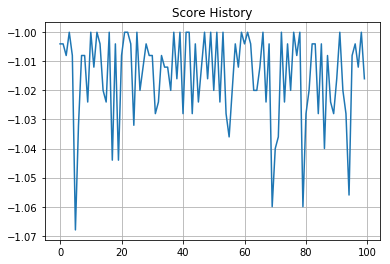

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure()
plt.title("Score History")
plt.grid()
plt.plot(scores)
plt.show()

よくわからないですが、再現性もなさそうであまり良くないように見えますね。
この解説では、いろいろな方法を使ってこの問題をよりよく解く方法を説明していきます。

## 環境=迷路の条件

ところで、今回の環境で用意した迷路は一定のルールに従っています。
それは以下の様に表され、このルールのことをマルコフ性といいます。

- 「遷移先の状態は直前の状態とそこでの行動のみに依存する」
- 「得られる報酬は直前の状態と遷移先に依存する」

強化学習ではこの条件を満たした環境であることを仮定して問題に取り組みます。
この条件を満たした環境のことをマルコフ決定過程（Marcov Decision Process:MDP)と呼びます。

## Dynamic Programming(動的計画法)
動的計画法は環境全体を見渡して、行動の「価値」が最大となるような行動を選択します。

動的計画法はアルゴリズム的なアプローチであり、試行錯誤して解を導くものではありません。
このアプローチでは、迷路で言えばそのマスに移動したときに得られる可能性のある価値（スコア）をシミュレーションして、それぞれのマスの価値を求めます。
そのマスに移動した時得られる可能性のあるスコアは実際にはその先のゴールまで行き着かないと計算することはできません。
動的計画法ではまずはある程度適当な値を設定した上で、少しずつ差分を小さくしていきある一定のしきい値を下回ったらそれを解とする手法です。

In [25]:
class ValueIterationPlanner:
    def __init__(self, env):
        self.env = env
        self.log = []
    
    def initialize(self):
        self.env.reset()
        self.log = []
    
    def plan(self, gamma=0.9, threshold=0.0001):
        self.initialize()
        actions = self.env.actions
        V = {}
        for s in self.env.states:
            V[s] = 0
        
        while True:
            delta = 0
            #self.log.append(self.dict_to_map(V))
            for s in V:
                if self.env.map[s.y][s.x] != 0:
                    continue
                expected_rewards = []
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    expected_rewards.append(r)
                max_reward = max(expected_rewards)
                delta = max(delta, abs(max_reward - V[s]))
                V[s] = max_reward
            if delta < threshold:
                break
        V_map = self.dict_to_map(V)
        return V_map
    
    # 現在地点からactionを行うときの行き先リストと確率
    def transitions_at(self, state, action):
        transition_probs = self.env.transition_probs(state, action)
        for next_state in transition_probs:
            prob = transition_probs[next_state]
            reward = self.env.get_current_reward(next_state)
            yield prob, next_state, reward
    
    def dict_to_map(self, state_reward_dict):
        value_map = []
        for i in range(self.env.y_length):
            row = [0] * self.env.x_length
            value_map.append(row)
        for s in state_reward_dict:
            value_map[s.y][s.x] = state_reward_dict[s]
        return value_map

それでは早速シミュレーションします。

In [26]:
scores = []
planner = ValueIterationPlanner(env)
V = np.array(planner.plan())

シミュレーションした結果をグラフ化します。ミドリが濃ければ濃いほど価値が高いことを表します。
(0, 0)のマスでは程々の高さで、ゴールの(5,4)の横である(4,4)が最も濃い色になっていることがわかるかと思います。

また、トラップマスは基本的に薄黄色（価値がない）と判断されています。

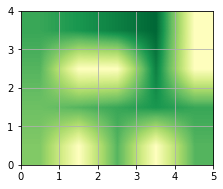

In [27]:
fig = plt.figure(figsize=(20,16))
ax = plt.subplot(env.y_length, env.x_length, 1)
plt.imshow(V, cmap=cm.RdYlGn, interpolation="bilinear", vmax=abs(V).max(), vmin=-abs(V).max())
ax.set_xlim(-0.5, env.x_length - 0.5)
ax.set_ylim(-0.5, env.y_length - 0.5)
ax.set_xticks(np.arange(-0.5, env.x_length, 1))
ax.set_yticks(np.arange(-0.5, env.y_length, 1))
ax.set_xticklabels(range(env.x_length + 1))
ax.set_yticklabels(range(env.y_length + 1))
ax.grid(which="both")
plt.show()

## 経験を積んで予測を行う

ここでは先程の動的計画法と違い、実際に経験してそこからモデルを作り上げる方法を見ていきます。



## ε-Delta

先程の動的計画法は、環境のモデルがすべてわからなければ利用できません。

ここからは、機械学習らしい方法に入っていきます。実際に試してみて、学習していくというある意味総当たり的な方法です。

ε-deltaは実績を重視しつつもたまに冒険するポリシーを利用して学習を進める方法です。
具体的には、基本的には実績を見てそれを尊重して行動するものの、εとして設定したパーセンテージだけ冒険し、さらに良い解を探していきます。

ε-deltaはあくまでもどう学習していくかという戦略です。実績を見るのは後述するMontecarloやQLearning(未作成）を利用します。

以下クラスでは戦略(policy)としてε-deltaが実装されたクラスを実装します。
実際には学習(learn)メソッドの実装が必要で、それをMontecarloやQLearningで実装します。

In [28]:
class ELAgent:
    def __init__(self, epsilon):
        self.Q = {}
        self.epsilon = epsilon
        self.reward_log = []
    
    # ポリシーに従ってアクションを実行します。
    # ここではself.epsilon %でランダムに行動し、1 - self,epsilon %で実績に基づいた行動を取ります
    def policy(self, state, actions):
        if np.random.random() < self.epsilon:
            return MazeAction(np.random.randint(len(actions)))
        else:
            if state in self.Q and sum(self.Q[state]) != 0:
                return MazeAction(np.argmax(self.Q[state]))
            else:
                return MazeAction(np.random.randint(len(actions)))
    
    def init_log(self):
        self.reward_log = []
        
    def log(self, reward):
        self.reward_log.append(reward)
    
    def show_reward_log(self, interval=50, episode=-1):
        if episode > 0:
            rewards = self.reward_log[-interval:]
            mean = np.round(np.mean(rewards), 3)
            std = np.round(np.std(rewards), 3)
            print("At Episode {} average reward is {} (+/-{})".format(episode, mean, std))
        
        else:
            indices = list(range(0, len(self.reward_log), interval))
            means = []
            stds = []
            for i in indices:
                rewards = self.reward_log[i:(i+interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            
            means = np.array(means)
            stds = np.array(stds)
            
            plt.figure()
            plt.title("Reward History")
            plt.grid()
            plt.fill_between(indices, means - stds, means + stds, alpha=0.1, color="g")
            plt.plot(indices, means, "o-", color="g", label="Rewards for each {} episode.".format(interval))
            plt.legend(loc="best")
            plt.show()

上のε-deltaクラスを利用して、MontrCarloを利用するAgentを実装していきます。

具体的にはlearnメソッドを実装します。
中身としてはself.Qに価値を格納していきます。

self.Qはself.Q[state][action]として使います。
この場合、stateにおけるactionの価値を表しています。

更新は、まず１エピソード分行動してその結果をベースにフィードバックします。
１エピソード実施すると、スタートからゴールまでの状態とそこで何をしたか、そこで何を得たかが経験として蓄積されます。
その結果を改めて見直して各状態であるアクションを取ってそこからゴールに行き着くまでに得られる価値を、その先の結果を減衰率γのt乗（その状態から遠ければ遠いほど大きくなる、つまり遠いものは得られるかわからないので少ししか信用しない的なノリ）をかけて計算します。

続ければ続けるほど、１つの状態からあるアクションを取ってゴールに行くまでの色々な経験ができてきますが、その経験を集約し平均することである状態からゴールに行きつける価値をそれぞれ算出していきます。

具体的な実装は以下のようになります。

In [30]:
import mathfrom collections import defaultdict

class MonteCarloAgent(ELAgent):
    
    def __init__(self, epsilon=0.1):
        super().__init__(epsilon)
        
    def learn(self, env, episode_count=1000, gamma=0.9, report_interval=50):
        self.init_log()
        self.Q = defaultdict(lambda: [0] * len(actions))
        N = defaultdict(lambda: [0] * len(actions))
        actions = list(range(len(env.actions)))
        
        for e in range(episode_count):
            s = env.reset()
            done = False
            experience = []
            total_reward = 0
            while not done:
                a = self.policy(s, actions)
                n_state, reward, done = env.step(a)
                experience.append({"state": s, "action": a, "reward": reward})
                s = n_state
                total_reward += reward
            else:
                self.log(total_reward)
                
            
            for i, x in enumerate(experience):
                s, a = x["state"], x["action"]
                G, t = 0, 0
                for j in range(i, len(experience)):
                    G += math.pow(gamma, t) * experience[j]["reward"]
                    t += 1
                
                N[s][a] += 1
                alpha = 1 / N[s][a]
                self.Q[s][a] += alpha * (G - self.Q[s][a])
            
            if e != 0 and e % report_interval == 0:
                self.show_reward_log(episode=e)

実装には関係ないですが、可視化のための関数を定義します。

In [29]:
import matplotlib.cm as cm

def show_q_value(env, Q): 
    ny = env.y_length
    nx = env.x_length
    state_size = 3
    q_ny = ny * state_size
    q_nx = nx * state_size
    reward_map = np.zeros((q_ny, q_nx))
    
    for y in range(ny):
        for x in range(nx):
            s = UserState(y, x)
            state_exist = False
            if isinstance(Q, dict) and s in Q:
                state_exist = True
            elif isinstance(Q, (np.ndarray, np.generic)) and s < Q.shape[0]:
                state_exist = True
            
            if state_exist:
                _y = 1 + y * state_size
                _x = 1 + x * state_size
                reward_map[_y][_x]     = np.mean(Q[s])
                reward_map[_y + 1][_x] = Q[s][MazeAction.UP.value]
                reward_map[_y - 1][_x] = Q[s][MazeAction.DOWN.value]
                reward_map[_y][_x - 1] = Q[s][MazeAction.LEFT.value]
                reward_map[_y][_x + 1] = Q[s][MazeAction.RIGHT.value]
            
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print(reward_map.max())
    print(reward_map.min())
    plt.imshow(reward_map, cmap=cm.RdYlGn, interpolation="bilinear", vmax=abs(reward_map).max(), vmin=-abs(reward_map).max())
    ax.set_xlim(-0.5, q_nx - 0.5)
    ax.set_ylim(-0.5, q_ny - 0.5)
    ax.set_xticks(np.arange(-0.5, q_nx, state_size))
    ax.set_yticks(np.arange(-0.5, q_ny, state_size))
    ax.set_xticklabels(range(nx + 1))
    ax.set_yticklabels(range(ny + 1))
    ax.grid(which="both")
    plt.show()

これで準備が整いました！
それでは実際に学習させてみましょう。

In [31]:
env.reset()
agent = MonteCarloAgent(epsilon=0.3)
agent.learn(env, episode_count=2000, report_interval=50)

At Episode 50 average reward is -1.155 (+/-0.17)
At Episode 100 average reward is -1.192 (+/-0.193)
At Episode 150 average reward is -1.127 (+/-0.199)
At Episode 200 average reward is -1.116 (+/-0.275)
At Episode 250 average reward is -1.07 (+/-0.267)
At Episode 300 average reward is -1.023 (+/-0.299)
At Episode 350 average reward is -1.017 (+/-0.361)
At Episode 400 average reward is -1.102 (+/-0.326)
At Episode 450 average reward is -1.091 (+/-0.289)
At Episode 500 average reward is -1.032 (+/-0.372)
At Episode 550 average reward is -1.017 (+/-0.341)
At Episode 600 average reward is -1.105 (+/-0.29)
At Episode 650 average reward is -1.007 (+/-0.436)
At Episode 700 average reward is -1.03 (+/-0.4)
At Episode 750 average reward is -1.012 (+/-0.381)
At Episode 800 average reward is -1.014 (+/-0.42)
At Episode 850 average reward is -0.89 (+/-0.578)
At Episode 900 average reward is -0.45 (+/-0.942)
At Episode 950 average reward is -0.205 (+/-0.95)
At Episode 1000 average reward is -0.243 (

結果を可視化してみます。
赤が濃ければ濃いほどマイナス、透明に近いところはプラマイゼロ、ミドリが濃ければ濃いほど価値が高いということを表します。

今回の場合、１つのマスを９つのセルに分割しています。
それぞれ、そのマスから進む方向に対して価値が表示されます。

例えば今回の場合濃い赤があるところ、例えば左下の(0,0)からは右に濃い赤があります。
右、つまり(1,0)は最初の定義上トラップがあるところでした。ポイント低いことがわかっている穴には落ちない、という価値観を表現していると言えます。

逆に(4,4)の右は濃い緑です。(5,4)はゴールなので最も価値が高いマスです。

1.0
-1.0


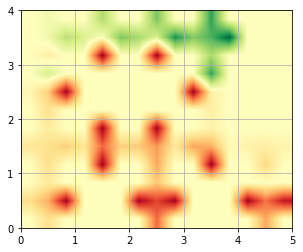

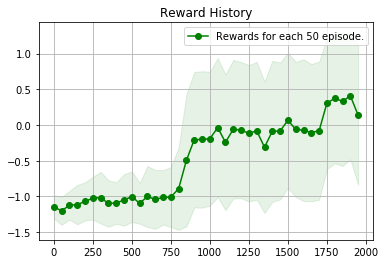

In [32]:
show_q_value(env, agent.Q)
agent.show_reward_log()